In [1]:
import pandas as pd
import numpy as np

In [2]:
#!pip install hazm

In [3]:
train=pd.read_csv('/content/PersianTwitterDataset.csv')
train

,Unnamed: 0,Tweets,Numeric Labels,Label
0,0,احساس می‌کنم غایت زندگی من اینه که یکی یروز بف...,4,Intense Emotions
1,1,ای بابا نصیب هرکسی نمیشه که، فقط دعای خیر پدر ...,0,Happy
2,2,با من مثل بقیه رفتار نکن آشغال,2,Angry
3,3,من علاقه شدیدی به شنیدن «بغلم کن» از طرف اونی ...,4,Intense Emotions
4,4,چیز کیک گرم و نرم میخوام.,0,Happy
...,...,...,...,...
3376,3376,مملکت نیست که تونل وحشته. بچه رو میبرن قاتل با...,2,Angry
3377,3377,قرار بود امتحانا که تموم شد مثلا یکم کصکلک کنم...,2,Angry
3378,3378,دوستان اون سه نقطه قرمز ها هست که میزنی باز می...,0,Happy
3379,3379,نتیجه ریسرچ کم‌کم داره به سمتی خوبی پیش میره,0,Happy


In [4]:
train['Label'].value_counts()

,count
Label,
Sad,1120
Happy,1057
Intense Emotions,415
Neutral,401
Angry,388


In [5]:
X_train = train.drop(columns=['Label'])
y_train = train['Label']

In [6]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
data_resampled, targets_resampled = ros.fit_resample(X_train, y_train)

In [7]:
targets_resampled.value_counts()

,count
Label,
Intense Emotions,1120
Happy,1120
Angry,1120
Sad,1120
Neutral,1120


In [8]:
data_resampled

,Unnamed: 0,Tweets,Numeric Labels
0,0,احساس می‌کنم غایت زندگی من اینه که یکی یروز بف...,4
1,1,ای بابا نصیب هرکسی نمیشه که، فقط دعای خیر پدر ...,0
2,2,با من مثل بقیه رفتار نکن آشغال,2
3,3,من علاقه شدیدی به شنیدن «بغلم کن» از طرف اونی ...,4
4,4,چیز کیک گرم و نرم میخوام.,0
...,...,...,...
5595,3059,به راهکارای درمان الزایمر نیاز دارم.,3
5596,555,این کودتا هم با همهٔ خوبی‌ها و بدی‌هاش تموم شد.,3
5597,2500,میشه ریتوییت کنین؟,3
5598,942,برنامه امشب: اچیومنت‌های ژاپن,3


In [9]:
from hazm import Normalizer, word_tokenize, stopwords_list
import string

normalizer = Normalizer()

def preprocessor(input):
    punc_removed = input.translate(str.maketrans('', '', string.punctuation))
    normalized = normalizer.normalize(punc_removed)
    tokens = word_tokenize(normalized)
    filtered = []
    for token in tokens:
        token = str(token)
        token = token.lower()
        if not token in stopwords_list() and not token.isdigit():
            filtered.append(token)
    output = ' '.join(filtered)
    return output

In [10]:
def tokenizer(text):
    return word_tokenize(text)

In [11]:
from sklearn.preprocessing import LabelEncoder

X_train = data_resampled['Tweets']
y_train = targets_resampled
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

In [12]:
X_train,y_train

(0       احساس می‌کنم غایت زندگی من اینه که یکی یروز بف...
 1       ای بابا نصیب هرکسی نمیشه که، فقط دعای خیر پدر ...
 2                          با من مثل بقیه رفتار نکن آشغال
 3       من علاقه شدیدی به شنیدن «بغلم کن» از طرف اونی ...
 4                               چیز کیک گرم و نرم میخوام.
                               ...                        
 5595                 به راهکارای درمان الزایمر نیاز دارم.
 5596      این کودتا هم با همهٔ خوبی‌ها و بدی‌هاش تموم شد.
 5597                                   میشه ریتوییت کنین؟
 5598                        برنامه امشب: اچیومنت‌های ژاپن
 5599                        *دختر سبزه با عینک وجود دارد*
 Name: Tweets, Length: 5600, dtype: object,
 array([2, 1, 0, ..., 3, 3, 3]))

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline


svm = Pipeline([('vect', CountVectorizer(tokenizer=tokenizer, preprocessor=preprocessor,
                                         analyzer='word', ngram_range=(1, 2),
                                         min_df=5, lowercase=False)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf-svm', LinearSVC(loss='hinge', penalty='l2', max_iter=5000))])

model = svm.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
from sklearn.metrics import f1_score

predictions = model.predict(X_train)
print('Training F1-score:', f1_score(y_train, predictions, average='weighted'))

Training F1-score: 0.8639940597160971


In [55]:
import glob

file_pattern = '/content/test(?).csv'

files = glob.glob(file_pattern)

dataframes = []

for file in files:
    df = pd.read_csv(file)
    dataframes.append(df)

file_pattern = '/content/test(??).csv'

files = glob.glob(file_pattern)

for file in files:
    df = pd.read_csv(file)
    dataframes.append(df)

test = pd.concat(dataframes, ignore_index=True)

test["Tweet Text"]

,Tweet Text
0,@Jebheiran چه خوشقدمه این پوزیده
1,@Jebheiran مسعود رو نگه میداریم هروقت ب سختی ا...
2,@Jebheiran 😂😂تنها رئیس جمهوریه که پاقدمش خیر بوده
3,@Jebheiran لگبرکت از سر و روش میباره میبینی
4,@Jebheiran واقعا ترسناکه
...,...
3344,@alilarijani_ir https://t.co/7eKNn9WAmg
3345,@alilarijani_ir https://t.co/JGpqtt7ySn
3346,@alilarijani_ir https://t.co/mzZZ3LL8iI
3347,@alilarijani_ir اسرائیل با آلت آمریکا می‌خواهد...


In [56]:
import re

def clean_comments(comment):
    comment = re.sub(r'@\w+', '', comment)
    comment = re.sub(r'http[s]?://\S+', '', comment)
    if comment == ' ':
        return np.nan
    return comment.strip()

test = test['Tweet Text'].apply(clean_comments)
test = test.dropna()
test

,Tweet Text
0,چه خوشقدمه این پوزیده
1,مسعود رو نگه میداریم هروقت ب سختی افتادیم میگی...
2,😂😂تنها رئیس جمهوریه که پاقدمش خیر بوده
3,لگبرکت از سر و روش میباره میبینی
4,واقعا ترسناکه
...,...
3338,کسکش بیناموس حرومزاده
3340,شهریه های دانشگاه آزاد باید به روال قبل برگردد...
3341,#FreeTurkActivists🕊️✊🏼🇦🇿#FreeAzActivists🕊️✊🏼🇦🇿
3343,لاری جان پاشو اون رباتتو روشن کنسوالم گرفته


In [57]:
X_test = test.copy()
predictions = model.predict(X_test)

In [58]:
submission = pd.DataFrame({'Tweet Text':test,'Label': encoder.inverse_transform(predictions)})
submission

,Tweet Text,Label
0,چه خوشقدمه این پوزیده,Happy
1,مسعود رو نگه میداریم هروقت ب سختی افتادیم میگی...,Intense Emotions
2,😂😂تنها رئیس جمهوریه که پاقدمش خیر بوده,Happy
3,لگبرکت از سر و روش میباره میبینی,Sad
4,واقعا ترسناکه,Happy
...,...,...
3338,کسکش بیناموس حرومزاده,Angry
3340,شهریه های دانشگاه آزاد باید به روال قبل برگردد...,Angry
3341,#FreeTurkActivists🕊️✊🏼🇦🇿#FreeAzActivists🕊️✊🏼🇦🇿,Happy
3343,لاری جان پاشو اون رباتتو روشن کنسوالم گرفته,Intense Emotions


In [59]:
submission['Label'].value_counts()

,count
Label,
Happy,1444
Angry,678
Sad,422
Neutral,390
Intense Emotions,325


In [60]:
value_counts = submission['Label'].value_counts()

percentages = (value_counts / value_counts.sum()) * 100

result_df = percentages.reset_index()
result_df.columns = ['Label', 'percentage']

result_df

,Label,percentage
0,Happy,44.308070
1,Angry,20.803928
2,Sad,12.948757
3,Neutral,11.966861
4,Intense Emotions,9.972384


In [61]:
result_df.set_index('Label',inplace=True)
result_df

,percentage
Label,
Happy,44.308070
Angry,20.803928
Sad,12.948757
Neutral,11.966861
Intense Emotions,9.972384


In [62]:
intense_percentage = result_df.loc['Intense Emotions']

result_df.loc['Happy'] += intense_percentage / 4
result_df.loc['Angry'] += intense_percentage / 4
result_df.loc['Sad'] += intense_percentage / 4
result_df.loc['Neutral'] += intense_percentage / 4
result_df.drop('Intense Emotions', inplace=True)
result_df

,percentage
Label,
Happy,46.801166
Angry,23.297024
Sad,15.441853
Neutral,14.459957


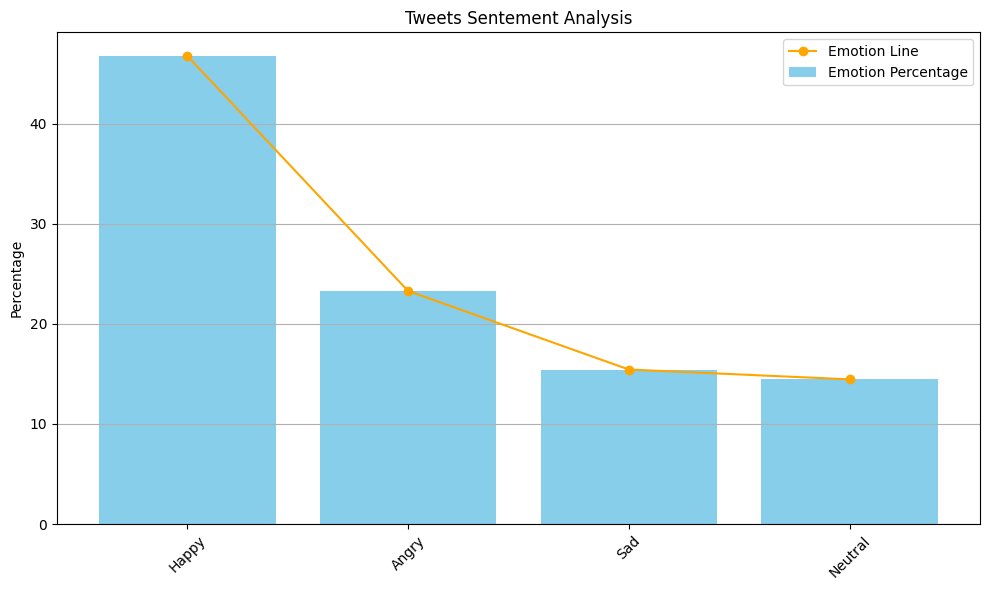

In [63]:
import matplotlib.pyplot as plt


result_df=result_df.reset_index()


plt.figure(figsize=(10, 6))
plt.bar(result_df['Label'], result_df['percentage'], color='skyblue', label='Emotion Percentage')
plt.ylabel('Percentage')
plt.title('Tweets Sentement Analysis')
plt.xticks(rotation=45)

plt.plot(result_df['Label'], result_df['percentage'], color='orange', marker='o', label='Emotion Line')

plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()